<a href="https://colab.research.google.com/github/RahulSrinivas8/deeplearning/blob/main/Text_Classification_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
import matplotlib.pyplot as plt

# Setup input pipeline

The IMDB large movie review dataset is a binary classification dataset, all the reviews have either a positive or negative sentiment.

Download the dataset using TFDS.

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7144L4/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7144L4/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7144L4/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

intially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ',example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these (text, label) pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

text:  [b"Let me make one thing clear\xc2\x85.for the most part, the mentality of those who run the show in Hollywood frankly p*sses me right off in general and even more specifically in relation to its treatment of much loved, iconic characters from the pages of comic books. Why? Well let's take a typical Hollywood executive board meeting scenario to illustrate shall we\xc2\x85..<br /><br />Executive no.1 'Hey there's lots of dollars to be gleaned from superhero flicks these days.' <br /><br />Executive no.2 'Good point, let's make one with haste then! \xc2\x96 We'll do a lucky dip in a hat and pick out a superhero at random to base a film upon!' (The dip takes place and a famous superheroes name is pulled out) <br /><br />Executive no.1 'Great! Now who can we get to play the part?' <br /><br />Executive no.2 'Who's a big box office star at the moment?' <br /><br />Executive no.1 '*name of big actor* is the in thing this week.' <br /><br />Executive no.2 'But does he really suit the r

# Create the text encoder

The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the TextVectorization layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[372,  70,  94, ...,   0,   0,   0],
       [869,  11,  18, ...,   0,   0,   0],
       [727,  43, 123, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

* The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
* The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Let me make one thing clear\xc2\x85.for the most part, the mentality of those who run the show in Hollywood frankly p*sses me right off in general and even more specifically in relation to its treatment of much loved, iconic characters from the pages of comic books. Why? Well let's take a typical Hollywood executive board meeting scenario to illustrate shall we\xc2\x85..<br /><br />Executive no.1 'Hey there's lots of dollars to be gleaned from superhero flicks these days.' <br /><br />Executive no.2 'Good point, let's make one with haste then! \xc2\x96 We'll do a lucky dip in a hat and pick out a superhero at random to base a film upon!' (The dip takes place and a famous superheroes name is pulled out) <br /><br />Executive no.1 'Great! Now who can we get to play the part?' <br /><br />Executive no.2 'Who's a big box office star at the moment?' <br /><br />Executive no.1 '*name of big actor* is the in thing this week.' <br /><br />Executive no.2 'But does he really suit th

# Create the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output.

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.0026309]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.0026309]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 108s 251ms/step - loss: 0.6343 - accuracy: 0.5762 - val_loss: 0.5507 - val_accuracy: 0.6469
Epoch 2/10
391/391 [==============================] - 94s 237ms/step - loss: 0.4410 - accuracy: 0.8001 - val_loss: 0.4484 - val_accuracy: 0.8297
Epoch 3/10
391/391 [==============================] - 94s 237ms/step - loss: 0.3618 - accuracy: 0.8415 - val_loss: 0.3552 - val_accuracy: 0.8396
Epoch 4/10
391/391 [==============================] - 94s 237ms/step - loss: 0.3330 - accuracy: 0.8569 - val_loss: 0.3413 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 95s 240ms/step - loss: 0.3153 - accuracy: 0.8654 - val_loss: 0.3301 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 93s 236ms/step - loss: 0.3094 - accuracy: 0.8691 - val_loss: 0.3440 - val_accuracy: 0.8359
Epoch 7/10
391/391 [==============================] - 96s 242ms/step - loss: 0.3050 - accuracy: 0.8711 - val_loss: 0.3341 - val_a

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 49s 126ms/step - loss: 0.3139 - accuracy: 0.8608
Test Loss: 0.31387951970100403
Test Accuracy: 0.860759973526001


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.651145938038826)

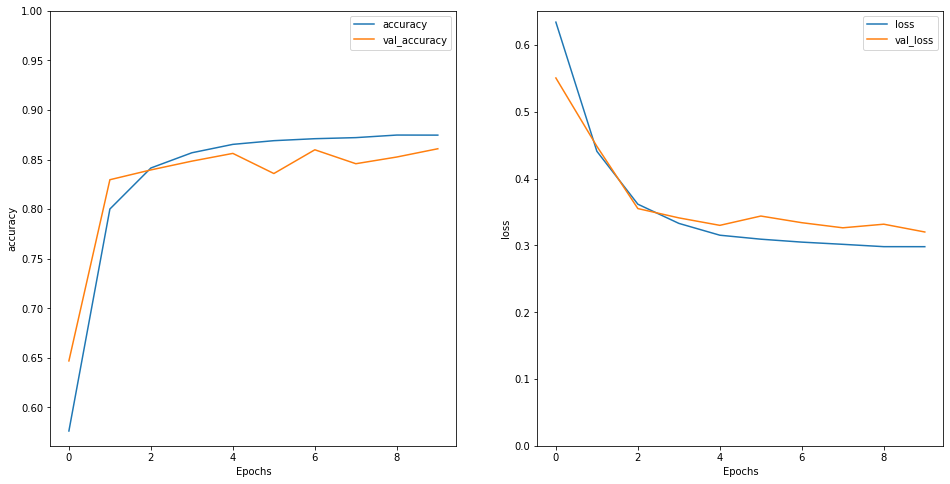

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.791841]]
